In [1]:
import torch
print("Using torch", torch.__version__)
import numpy as np
import os
import time
from torch import nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.autograd import grad
import torch.utils.data as data

import matplotlib.pyplot as plt

%matplotlib inline

Pi = np.pi

Using torch 1.13.0


In [2]:
#a very simple torch method to compute derivatives.
def nth_derivative(f, wrt, n):
    for i in range(n):
        grads = grad(f, wrt, create_graph=True, allow_unused=True)[0]
        f = grads
        if grads is None:
            print('bad grad')
            return torch.tensor(0.)
    return grads

def flat(x):
    m = x.shape[0]
    return [x[i] for i in range(m)]

In [3]:
# This class is a general Neural Network (fully connected, feed forward neural network), a.k.a Multi Layer Perceptron (MLP)
# Our PINN will be represented by a neural network of this type
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.il  = nn.Linear(2,20)   # The input layer (2 nodes) is mapped to the first hidden layer (with 20 nodes)
        self.hl1  = nn.Linear(20,200) # The first hidden layer (20 nodes) is mapped to the second hidden layer (with 20 nodes)
        self.hl2 = nn.Linear(200,200)  # ""
        self.hl3 = nn.Linear(200,200)  # ""
        self.hl4 = nn.Linear(200,200)  # ""
        self.hl5 = nn.Linear(200,20)  # ""
        self.ol  = nn.Linear(20,1)   # The last hiddlen layer (20 nodes) is mapped to the output layer (with 1 node, which represents the scalar value of u in Burger's PDE)

        self.tn  = nn.Tanh() # defining activation function

    def forward(self, x, t):
        # Here we compose the various input/hidden/output layers together, with nonlinear activiation functions in between
        # This composition makes up the neural network function
        u = torch.cat((x, t), 1)
        u = self.il(u)
        u = self.hl1(self.tn(u))
        u = self.hl2(self.tn(u))
        u = self.hl3(self.tn(u))
        u = self.hl4(self.tn(u))
        u = self.hl5(self.tn(u))
        u = self.ol(u)
        return u

In [4]:
# Parameters
h = 1.0
mu = 0.6; rho = 0.5;
N = 32;
dpdx = -2.0; gx = 0.0;
V1 = 0.0; V2 = 0.0;
al = 0.51;
nstep = 20000
nu = mu/rho
Dy = h/N;
Dt = al*Dy*Dy/nu;

def unidirectional_equation(y,t,model):    
    u = model(y,t)
    u_t = nth_derivative(flat(u), t, 1)
    u_y = nth_derivative(flat(u), y, 1)
    u_yy = nth_derivative(flat(u_y), y, 1)
    f = -u_t - 1/rho*dpdx + nu*u_yy + gx
    return f

In [5]:
class BC_Data(data.Dataset):
    def __init__(self, nt, ny):
        """
        Inputs:
            ny - number of points used to sample boundary conditions in y
            nt - number of points used to sample boundary conditions in t
        """
        super().__init__()
        self.nt = nt
        self.ny = ny
        self.generate_bc_data()

    def generate_bc_data(self):
        # u(y,t=0) = 0
        y = np.linspace(0,1,self.ny)
        y_bc = torch.from_numpy(y).float()
        t_bc = torch.from_numpy(np.zeros(self.ny)).float()
        u_bc = torch.from_numpy(np.zeros(self.ny)).float()

        # u(y=0,t) = 0
        y_bc = torch.cat((y_bc, torch.from_numpy(np.zeros(self.nt)).float()))
        t_bc = torch.cat((t_bc, torch.from_numpy(np.linspace(0,1,self.nt)).float()))
        u_bc = torch.cat((u_bc, torch.from_numpy(np.zeros(self.nt)).float()))

        # u(y=1,t) = 0
        y_bc = torch.cat((y_bc, torch.from_numpy(np.ones(self.nt)).float())).reshape(-1,1)
        t_bc = torch.cat((t_bc, torch.from_numpy(np.linspace(0,1,self.nt)).float())).reshape(-1,1)
        u_bc = torch.cat((u_bc, torch.from_numpy(np.zeros(self.nt)).float())).reshape(-1,1)

        y_bc.requires_grad = True
        t_bc.requires_grad = True
        u_bc.requires_grad = False

        self.y = y_bc
        self.t = t_bc
        self.u = u_bc

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.y.shape[0]

    
class RandCollocationPoints(data.Dataset):

    def __init__(self, n_coll_pts):
        """
        Inputs:
            n_coll_pts - Number of randomly selected collocation points
        """
        super().__init__()
        self.n_coll_pts = n_coll_pts
        self.generate_coll_points()

    def generate_coll_points(self):
    
        y = np.random.uniform(0,1, self.n_coll_pts) # uniform random sampling of y between 0 and 1
        t = np.random.uniform(0,1, self.n_coll_pts) # uniform random sampling of t between 0 and 1
        
        y = torch.from_numpy(y).float().reshape(-1,1)
        t = torch.from_numpy(t).float().reshape(-1,1)
        
        y.requires_grad = True
        t.requires_grad = True
        
        self.y = y
        self.t = t

In [6]:
# Setting random seeds so that the results can be exactly reproduced
np.random.seed(88)
torch.random.manual_seed(88)

# Create Boundary condition data (object of the BC_Data class)
bc_data = BC_Data(nt = 256, ny = 256)

In [7]:
# Initialize nn_model
pinn = MLP()

# Create empty lists to track optimization progress of the boundary conditions (L_bc) + optimization of PDE (L_pde)
L_bc_evol = []
L_pde_evol = []

# Initialize optimizer -- Setting pinn parameters as the parameters to be optimized. Starting with a learning rate lr = 0.001 (good rule of thumb)
optimizer = optim.Adam(pinn.parameters(), lr=0.001)


num_epochs = 20001 # This sets the number of optimization iterations 

for epoch in range(num_epochs):
    ###################################################################
    # Evaluate discrepancy relative to the boundary conditions (L_bc)
    ###################################################################
    pinn_at_bc_pts = pinn(bc_data.y, bc_data.t) # evaluating pinn at boundary y and t values
    L_bc = torch.mean(torch.pow(pinn_at_bc_pts - bc_data.u,2)) # computing mean squared error between pinn and boundary condition values
    ###################################################################

    
    ###################################################################
    # Evaluate discrepancy relative to the Burger's PDE (L_PDE)
    ###################################################################
    coll_pts = RandCollocationPoints(n_coll_pts = 400) # randomly select n_coll_pts = 400 in the domain y in [-1,1] and t in [0,1] to evaluate PDE discrepancy; these are called collocation points; a new set of random collocation points is generated at each optimization iteration
    pinn_at_coll_pts = unidirectional_equation(torch.cat((bc_data.y,coll_pts.y)), torch.cat((bc_data.t,coll_pts.t)), pinn) # evaluate PDE residual at collocation points; here we concatenate the (y,t) values at the boundaries with the (y,t) values of the collocation points

    L_pde = torch.mean(torch.pow(pinn_at_coll_pts,2)) # computing mean squared error of the PDE residuals
    ###################################################################
    
    
    ###################################################################
    # Optimize PINN parameters
    ###################################################################
    L_bc_pde = L_bc + L_pde # Combine the boundary condition and PDE residuals
    
    # Now we optimize (always done by these 3 steps):
    optimizer.zero_grad() # set all gradients previously calculated to zero
    L_bc_pde.backward() # compute gradient of our objective function (that we want to minimize) with respect to the parameters of the PINN
    optimizer.step() # update the parameters of the PINN according to gradient descent
    ###################################################################
    
    # Append L_bc and L_pde values to track their evolution
    L_bc_evol.append(L_bc.item())
    L_pde_evol.append(L_pde.item())
    
    if (epoch % 500 == 0) or (epoch == num_epochs-1):
        print('epoc = ', epoch)
        print('loss = ', float(L_bc_pde))
    if epoch % 5000 == 0:
        torch.save(pinn.state_dict(), 'unidirectional_model')
        

epoc =  0
loss =  16.106618881225586
epoc =  500
loss =  0.01863725110888481
epoc =  1000
loss =  0.005662982352077961
epoc =  1500
loss =  0.02555680274963379
epoc =  2000
loss =  0.0037797167897224426
epoc =  2500
loss =  0.0035663540475070477
epoc =  3000
loss =  0.0034127305261790752
epoc =  3500
loss =  0.002852723002433777
epoc =  4000
loss =  0.0025003061164170504
epoc =  4500
loss =  0.0020364809315651655
epoc =  5000
loss =  0.0021799213718622923
epoc =  5500
loss =  0.0015416615642607212
epoc =  6000
loss =  0.0012038142886012793
epoc =  6500
loss =  0.0026684515178203583
epoc =  7000
loss =  0.0006759037496522069
epoc =  7500
loss =  0.0008192509412765503
epoc =  8000
loss =  0.0014814641326665878
epoc =  8500
loss =  0.0005766540998592973
epoc =  9000
loss =  0.0010880313348025084
epoc =  9500
loss =  0.0027889125049114227
epoc =  10000
loss =  0.00031757698161527514
epoc =  10500
loss =  0.0010568252764642239
epoc =  11000
loss =  0.0005985814495943487
epoc =  11500
loss =

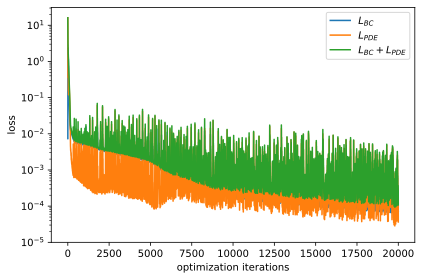

In [11]:
plt.semilogy(L_bc_evol, label = r'$L_{BC}$')
plt.semilogy(L_pde_evol, label = r'$L_{PDE}$')
plt.semilogy(np.array(L_bc_evol) + np.array(L_pde_evol), label = r'$L_{BC}+L_{PDE}$')
plt.ylabel('loss')
plt.xlabel('optimization iterations')
plt.ylim(1e-5,)
plt.legend()
plt.tight_layout()

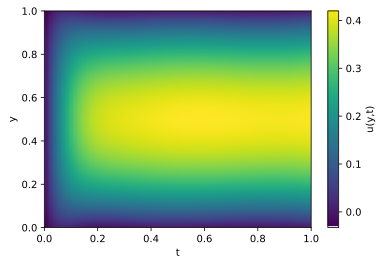

In [14]:
# Plotting the PINN solution:
vtn = 64
vyn = 128
vy = np.linspace (0, 1, vyn )
vt = np.linspace (0, 1, vtn )
Vy, Vt = np.meshgrid(vy,vt)
Vy = torch.FloatTensor(Vy.flatten().reshape(-1,1))
Vt = torch.FloatTensor(Vt.flatten().reshape(-1,1))
u = pinn(Vy,Vt).reshape(vtn,vyn)
u = u.detach().numpy().T

plt.imshow(u, origin = 'lower', extent = [0,1,0,1], aspect='auto')
plt.xlabel('t')
plt.ylabel('y')
plt.colorbar(label = 'u(y,t)')

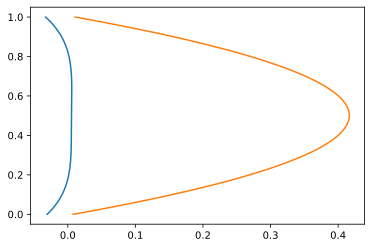

In [19]:
plt.plot(u[:,0], vy)
plt.plot(u[:,-1], vy)